# Getting Started Comparing Hand Annotated Blinks with OF and Glasses
We've hand annotated some of Patrick 3 with the 'Hand Annotate Videos' script, now let's see how we did.

We need to load in our hand annotations `hand_annotations` from `hand_annotations.p`, which is a dictionary with key = index of video session, value = array of timestamps of hand labels.

We need to load in our video sessions with the openface labels `vid_meta_data` from `video_blink_sessions.p`.  We'll just use the sessions we have hand annotations for.

We need to load in our glasses blink data, time corrected.  We can either load in
- (1) the results from our baseline classifier df, which is a df that includes a timestamp, duration, and peak velocities for each blink we identified, from `glasses_all_blink_timestamps_uncorrected.p`.  This is without the timestamp correction to align it with video, so we also need to load and apply `best_offset.p` to time align the blinks properly.
- (2) we could load in the raw `blink_sess` from `sessions_blink.p`, which is the raw data right off the sensor.  This is also not time corrected and we'll need to apply `best_offset.p`

Finally, we may need to load in `sessions_accel.p` if it turns out we need to use the accelerometer data to try and remove blink artifacts based on motion.  Again, this glasses data will need to have `best_offset.p` applied to its timestamps before using it.

In [26]:
import json
from datetime import datetime , timezone
import time
import numpy as np
import codecs
import struct
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pycorrelate
import collections
import itertools
from mpl_toolkits import mplot3d
import cv2
import imutils
import os
from scipy.spatial.transform import Rotation as R

pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', 1000)
%matplotlib inline

### Step 1: Load Data (and correct glasses time offset to align everything)

In [27]:
metadata = pickle.load(open('./cleaned_data/metadata.p', 'rb'))
print('Please Choose a Session to Work With:')
for k in metadata: print(k, end=',  ')

Please Choose a Session to Work With:
david_2,  patrick_1,  patrick_2,  beata_1,  david_3b,  irmandy_1,  juliana_1,  irmandy_2,  patrick_3,  

In [28]:
SESSION = 'patrick_3'

In [29]:
hand_annotations = pickle.load(open('./cleaned_data/' + SESSION + '/hand_annotations.p', "rb" ))

vid_meta_data = pickle.load(open('./cleaned_data/' + SESSION + '/video_blink_sessions.p', "rb" ))

best_offset = pickle.load(open('./cleaned_data/' + SESSION + '/best_offset.p', "rb" ))

accel_sess = pickle.load(open('./cleaned_data/' + SESSION + '/sessions_accel.p', "rb" ))
for i in range(len(accel_sess)): accel_sess[i]['timestamp_ms'] = accel_sess[i]['timestamp_ms'] + best_offset

df_glasses_blinks = pickle.load(open('./cleaned_data/' + SESSION + '/glasses_all_blink_timestamps_uncorrected.p', "rb" ))
df_glasses_blinks['timestamp_ms'] = df_glasses_blinks['timestamp_ms'] + best_offset

In [30]:
total_blinks, total_dur_sec, total_num_skipped, total_dur_skipped, of_blinks_skipped = 0, 0, 0, 0, 0
for k in hand_annotations:
    try:
        total_blinks += len(hand_annotations[k])
        total_dur_sec += vid_meta_data['duration_sessions_sec'][k]
    except:
        total_num_skipped +=1
        total_dur_skipped += vid_meta_data['duration_sessions_sec'][k]
        of_blinks_skipped += vid_meta_data['blinks_per_session'][k]

print('hand annotations represent %d blinks with %3.2f secs of recording.  That\'s a blink rate of %2.2f blinks/min.'%(total_blinks, total_dur_sec, 60*total_blinks/total_dur_sec))
print('skipped %d snippets with %3.2f sec of recording.  These are probably worse for OF because they were hard to classify by eye.'%(total_num_skipped, total_dur_skipped))
print('skipped sections include %d blinks found by openface.'%of_blinks_skipped)

hand annotations represent 507 blinks with 1855.35 secs of recording.  That's a blink rate of 16.40 blinks/min.
skipped 5 snippets with 296.51 sec of recording.  These are probably worse for OF because they were hard to classify by eye.
skipped sections include 80 blinks found by openface.


#### Now we will eliminate the sections we skipped when hand annotating
We skipped some sections during annotation because of the ambiguity/difficulty and saved them as 'None'.  OF would likely struggle with these, but we can't even really tell ourselves; OF shouldn't have been confident.  We'll work just with our known good data now and eliminate values of 'None' from our hand annotations.

In [31]:
filtered = {k: v for k, v in hand_annotations.items() if v is not None}
hand_annotations.clear()
hand_annotations.update(filtered)

### Step 2: For simplicity, add motion to df_glasses_blinks and remove accel_sess, since we won't need it anymore

In [32]:
def df_between_timestamps(df, time_col, start_time, end_time):
    return df[(start_time <= df[time_col]) & (df[time_col] <= end_time)].copy()

def rotation_mag_between_rows(row_start, row_end):
    rotation = R.from_quat(row_start[['quatReal', 'quatI', 'quatJ', 'quatK']]).inv() * R.from_quat(row_end[['quatReal', 'quatI', 'quatJ', 'quatK']])
    return rotation.magnitude()
    
def get_rotation_mag_by_timestamp(timestamp):
    for sess in accel_sess:
        #if our timestamp is in this session
        if sess['timestamp_ms'].iloc[0] <= timestamp <= sess['timestamp_ms'].iloc[-1]:
            #get the two closest timestamps
            df_closest = sess.iloc[(sess['timestamp_ms']-timestamp).abs().argsort()[:2]]
            #return the rotation of these two
            return rotation_mag_between_rows(df_closest.iloc[0], df_closest.iloc[1])
    #if we fail to find it in our glasses data for acceleration, return np.nan
    return np.nan

In [33]:
df_glasses_blinks['rotation_magnitude'] = df_glasses_blinks.apply(lambda row: get_rotation_mag_by_timestamp(row['timestamp_ms']), axis=1)
del accel_sess
df_glasses_blinks.head(10)

,duration_ms,timestamp_ms,vel_close,vel_open,rotation_magnitude
0,45.000,1617719302160.000,0.182,0.186,0.000
1,183.000,1617719302292.000,0.182,0.193,0.000
2,57.000,1617719302421.000,0.179,0.193,0.000
3,151.000,1617719482415.000,0.202,0.168,0.000
4,43.000,1617719485243.000,0.074,0.048,0.000
5,541.000,1617719485445.000,0.120,0.169,0.000
6,541.000,1617719485575.000,0.120,0.169,0.000
7,85.000,1617719487433.000,0.061,0.043,0.000
8,50.000,1617719490138.000,0.222,0.222,0.004
9,705.000,1617720281650.000,0.262,0.020,0.000


We now have clean, easy to use and work with data that is all time aligned!

`vid_meta_data` - a dict with sessions of good tracking from OF, timestamped at the start and end, as well as lists of timestamps of blink events.

`hand_annotations` - a dict where the key indexes the session from `vid_meta_data`, and the value is a list of timestamps of blink events.

`df_glasses_blinks` - a df where every row represents a blink captured by our glasses/basic glasses algorithm, timestamped, and including blink duration, vel_open, vel_close, and rotation_magnitude of the head during that blink.

### Step 3: Compare Hand Annotations with Blink Classification from OF and the Glasses

We'll start by simply: 

(1) printing basic hand annotation data (duration annotated, blinks/sec, number of sessions, number of blinks, etc)

(2) reducing our blink list for glasses and video into one list for each, which only includes blinks that occur during our hand anotation sections.

(3) comparing the OF list and the glasses list to the hand annotation list.  Iterate over real blink times, removing first instance of classified blink that falls within some error bar.  Get metrics for true/false positives and compare.

(4) store indices of glasses blinks that are false positives, and create a df for true positives and false positives.  Look at differences between vel/duration/rotation_mag when true or false positive.

(5) plot(?) each over top of one another?  May be useful



In [34]:
#get glasses blinks that occur during hand annotation timing (df_gblinks), get lists of just timestamps for glasses (gblinks), openface (vblinks), and annotated (ablinks)
glasses_blinks_during_handannotate_times = []
vblinks, ablinks = [], []

for i in hand_annotations:
    glasses_blinks_during_handannotate_times.append(df_between_timestamps(df_glasses_blinks, 
                                                  'timestamp_ms', 
                                                  vid_meta_data['session_times'][i][0], 
                                                  vid_meta_data['session_times'][i][1]))
    
    vblinks.extend(vid_meta_data['blink_timestamps_per_session'][i])
    ablinks.extend(hand_annotations[i])
    
df_gblinks = pd.concat(glasses_blinks_during_handannotate_times)
gblinks = df_gblinks['timestamp_ms'].tolist()

In [35]:
print('Got:')
print('\t%5d blinks (openface)'%len(vblinks))
print('\t%5d blinks (glasses)' %len(gblinks))
print('\t%5d blinks (annotated)'%len(ablinks))

Got:
	  620 blinks (openface)
	 1166 blinks (glasses)
	  507 blinks (annotated)


In [36]:
def debounce_data(list_of_times, debounce_dur_ms=200):
    
    indices_to_remove = []
    for i in range(1, len(list_of_times)):
        if list_of_times[i-1] >= list_of_times[i] - debounce_dur_ms:
            indices_to_remove.append(i)

    for index in sorted(indices_to_remove, reverse=True):
        del list_of_times[index]
        
    return list_of_times

def test_results(annotated_blinklist, test_blinklist, tolerance_ms=500):
    results = {'true_pos':0, 'real_pos':len(annotated_blinklist)}

    for  atime in annotated_blinklist:
        for ttime in test_blinklist:
            if ttime-tolerance_ms <= atime <= ttime+tolerance_ms:
                results['true_pos'] += 1
                test_blinklist.remove(ttime)
                break
    results['false_pos'] = len(test_blinklist)
    results['sensitivity'] = results['true_pos'] / results['real_pos'] * 100
    results['false_discovery'] = results['false_pos'] / (results['false_pos'] + results['true_pos']) * 100
    
    return results, test_blinklist

In [37]:
#test different error margins
for margin in [400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]:
    g = gblinks.copy()
    v = vblinks.copy()
    gresults, false_pos_times = test_results(ablinks, g, margin)
    print('%4d: glasses: '%(margin),gresults)
    vresults, _ = test_results(ablinks, v, margin)
    print('%4d openface:'%(margin),vresults)

 400: glasses:  {'true_pos': 363, 'real_pos': 507, 'false_pos': 803, 'sensitivity': 71.59763313609467, 'false_discovery': 68.86792452830188}
 400 openface: {'true_pos': 352, 'real_pos': 507, 'false_pos': 268, 'sensitivity': 69.42800788954635, 'false_discovery': 43.225806451612904}
 500: glasses:  {'true_pos': 382, 'real_pos': 507, 'false_pos': 784, 'sensitivity': 75.34516765285996, 'false_discovery': 67.23842195540308}
 500 openface: {'true_pos': 358, 'real_pos': 507, 'false_pos': 262, 'sensitivity': 70.61143984220908, 'false_discovery': 42.25806451612903}
 600: glasses:  {'true_pos': 404, 'real_pos': 507, 'false_pos': 762, 'sensitivity': 79.6844181459566, 'false_discovery': 65.35162950257289}
 600 openface: {'true_pos': 365, 'real_pos': 507, 'false_pos': 255, 'sensitivity': 71.99211045364892, 'false_discovery': 41.12903225806452}
 700: glasses:  {'true_pos': 434, 'real_pos': 507, 'false_pos': 732, 'sensitivity': 85.60157790927022, 'false_discovery': 62.778730703259}
 700 openface: {'t

## RUN UP TO HERE

look for best margin, type below

In [38]:
BEST_MARGIN = 1400

#gblinks_debounce = debounce_data(gblinks)
gresults, false_pos_times = test_results(ablinks, gblinks, BEST_MARGIN)
print('glasses: ',gresults)

vresults, _ = test_results(ablinks, vblinks, BEST_MARGIN)
print('openface:',vresults)

glasses:  {'true_pos': 503, 'real_pos': 507, 'false_pos': 663, 'sensitivity': 99.21104536489152, 'false_discovery': 56.861063464837045}
openface: {'true_pos': 385, 'real_pos': 507, 'false_pos': 235, 'sensitivity': 75.93688362919131, 'false_discovery': 37.903225806451616}


In [39]:
df_gblinks['asym'] = df_gblinks['vel_close']-df_gblinks['vel_open']
df_gblinks['weighted_asym'] = (df_gblinks['vel_close']-df_gblinks['vel_open'])/(df_gblinks['vel_close']+df_gblinks['vel_open'])

df_gblinks.head()


,duration_ms,timestamp_ms,vel_close,vel_open,rotation_magnitude,asym,weighted_asym
5801,117.000,1617754006691.000,0.209,0.077,0.001,0.132,0.462
5802,173.000,1617754008206.000,0.201,0.058,0.001,0.143,0.554
5803,224.000,1617754010194.000,0.100,0.012,0.002,0.088,0.786
5804,120.000,1617754010573.000,0.170,0.156,0.001,0.014,0.042
5805,95.000,1617754011338.000,0.305,0.090,0.001,0.215,0.546


In [40]:
gblinks_success = df_gblinks[~df_gblinks['timestamp_ms'].isin(false_pos_times)]
gblinks_failed  = df_gblinks[df_gblinks['timestamp_ms'].isin(false_pos_times)]

In [41]:
print(len(gblinks_success))
print(len(gblinks_failed))

503
663


<AxesSubplot:>

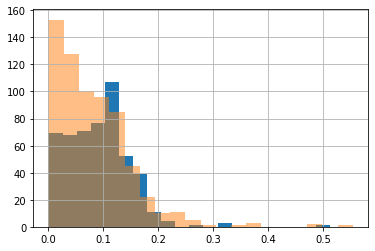

In [42]:
gblinks_success['vel_open'].hist(bins=20)
gblinks_failed['vel_open'].hist(bins=20,alpha=0.5)

<AxesSubplot:>

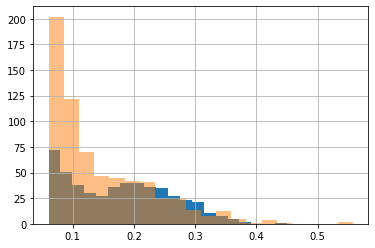

In [43]:
gblinks_success['vel_close'].hist(bins=20)
gblinks_failed['vel_close'].hist(bins=20,alpha=0.5)

<AxesSubplot:>

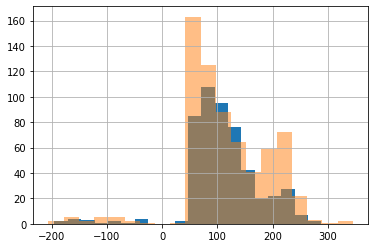

In [44]:
gblinks_success['duration_ms'].hist(bins=20)
gblinks_failed['duration_ms'].hist(bins=20,alpha=0.5)

<AxesSubplot:>

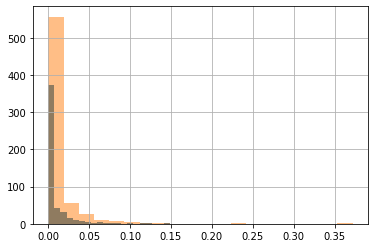

In [45]:
gblinks_success['rotation_magnitude'].hist(bins=20)
gblinks_failed['rotation_magnitude'].hist(bins=20, alpha=0.5)

<AxesSubplot:>

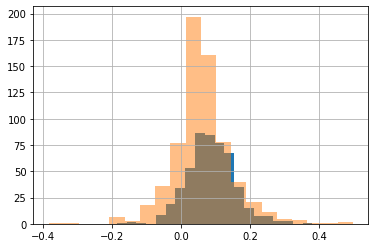

In [46]:
gblinks_success['asym'].hist(bins=20)
gblinks_failed['asym'].hist(bins=20, alpha=0.5)

<AxesSubplot:>

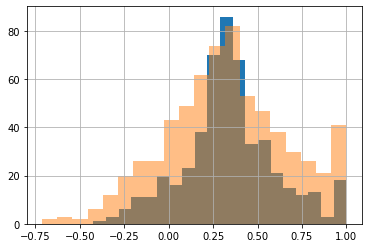

In [47]:
gblinks_success['weighted_asym'].hist(bins=20)
gblinks_failed['weighted_asym'].hist(bins=20, alpha=0.5)

In [51]:
#lets filter our blink list by IF vel_close < 0.12 and/or vel_open < 0.05 and retest
gblinks = df_gblinks['timestamp_ms'].tolist()
#gblinks_filtered1 = df_gblinks[(df_gblinks['vel_open'] > 0.05) & (df_gblinks['vel_close'] > 0.12)]['timestamp_ms'].tolist()
#gblinks_filtered2 = df_gblinks[(df_gblinks['vel_open'] > 0.05) | (df_gblinks['vel_close'] > 0.12)]['timestamp_ms'].tolist()
gblinks_filtered1 = df_gblinks[(df_gblinks['weighted_asym'] < 0.5) & (df_gblinks['weighted_asym'] > 0.0)]['timestamp_ms'].tolist()
gblinks_filtered2 = df_gblinks[(df_gblinks['duration_ms'] > 50) & (df_gblinks['vel_open'] < 0.4) & (df_gblinks['vel_close'] < 0.4)]['timestamp_ms'].tolist()




print('filtered out', len(gblinks)-len(gblinks_filtered1),'results')
gresults, false_pos_times = test_results(ablinks, gblinks, BEST_MARGIN)

print('original glasses: ',gresults)
gresults, false_pos_times = test_results(ablinks, gblinks_filtered1, BEST_MARGIN)
print('filtered glasses: ',gresults)
gresults, false_pos_times = test_results(ablinks, gblinks_filtered2, BEST_MARGIN)
print('filtered glasses: ',gresults)

filtered out 482 results
original glasses:  {'true_pos': 503, 'real_pos': 507, 'false_pos': 663, 'sensitivity': 99.21104536489152, 'false_discovery': 56.861063464837045}
filtered glasses:  {'true_pos': 431, 'real_pos': 507, 'false_pos': 253, 'sensitivity': 85.00986193293886, 'false_discovery': 36.98830409356725}
filtered glasses:  {'true_pos': 501, 'real_pos': 507, 'false_pos': 569, 'sensitivity': 98.81656804733728, 'false_discovery': 53.17757009345795}


In [55]:
gblinks = df_gblinks['timestamp_ms'].tolist()
gblinks_filtered1 = df_gblinks[(df_gblinks['vel_open'] > 0.05) | (df_gblinks['vel_close'] > 0.12)]['timestamp_ms'].tolist()
gblinks_filtered2 = df_gblinks[((df_gblinks['vel_open'] > 0.06) | (df_gblinks['vel_close'] > 0.12)) & (df_gblinks['rotation_magnitude'] < 0.05)]['timestamp_ms'].tolist()


print('filtered out', len(gblinks)-len(gblinks_filtered1),'results')
gresults, false_pos_times = test_results(ablinks, gblinks, BEST_MARGIN)

print('original glasses: ',gresults)
gresults, false_pos_times = test_results(ablinks, gblinks_filtered1, BEST_MARGIN)
print('filtered glasses: ',gresults)
gresults, false_pos_times = test_results(ablinks, gblinks_filtered2, BEST_MARGIN)
print('filtered glasses: ',gresults)

filtered out 268 results
original glasses:  {'true_pos': 503, 'real_pos': 507, 'false_pos': 663, 'sensitivity': 99.21104536489152, 'false_discovery': 56.861063464837045}
filtered glasses:  {'true_pos': 486, 'real_pos': 507, 'false_pos': 412, 'sensitivity': 95.85798816568047, 'false_discovery': 45.87973273942094}
filtered glasses:  {'true_pos': 468, 'real_pos': 507, 'false_pos': 336, 'sensitivity': 92.3076923076923, 'false_discovery': 41.7910447761194}


In [56]:
#lets save our results!
final_results = {}

vblinks = []
for i in hand_annotations: vblinks.extend(vid_meta_data['blink_timestamps_per_session'][i])
vresults, _ = test_results(ablinks, vblinks, BEST_MARGIN)
final_results['openface'] = vresults

gblinks = df_gblinks['timestamp_ms'].tolist()
gresults, _ = test_results(ablinks, gblinks, BEST_MARGIN)
final_results['glasses'] = gresults

gblinks_filtered = df_gblinks[(df_gblinks['vel_open'] > 0.05) | (df_gblinks['vel_close'] > 0.12)]['timestamp_ms'].tolist()
gresults, _ = test_results(ablinks, gblinks_filtered, BEST_MARGIN)
final_results['glasses_filtered'] = gresults

print(final_results)

{'openface': {'true_pos': 385, 'real_pos': 507, 'false_pos': 235, 'sensitivity': 75.93688362919131, 'false_discovery': 37.903225806451616}, 'glasses': {'true_pos': 503, 'real_pos': 507, 'false_pos': 663, 'sensitivity': 99.21104536489152, 'false_discovery': 56.861063464837045}, 'glasses_filtered': {'true_pos': 486, 'real_pos': 507, 'false_pos': 412, 'sensitivity': 95.85798816568047, 'false_discovery': 45.87973273942094}}


In [57]:
pickle.dump(final_results, open( './cleaned_data/' + SESSION + '/final_results.p', "wb" ))